In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-89fhzkvk
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-89fhzkvk
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=267005 sha256=773cdbad948c81d5ebb54e1cee78675550b43fc8acb32ac98c2bb0efdec670e8
  Stored in directory: /tmp/pip-ephem-wheel-cache-ni6le7ge/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free

In [2]:
# mount your gdrive folder
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/ML


/content/drive/My Drive/ML


In [4]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 1.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200630-cp36-none-any.whl size=41299 sha256=2e49eba1fd5dd20a9365be97f0cf0236899b77bc1b435dffdd00bb5fcd85f2a8
  Stored in directory: /root/.cache/pip/wheels/80/eb/49/83b9d20a804f1b4b163d1c1451c670a2067a00175662516f01
Successfully built fvcore


In [5]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger

import detectron2
from detectron2.utils.logger import setup_logger
#setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


In [6]:

# Register a dataset in COCO’s json annotation format for instance detection, instance segmentation and keypoint detection. 
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/My Drive/ML/all_May_2020/train/trainval.json", "/content/drive/My Drive/ML/all_May_2020/train/images")
register_coco_instances("my_dataset_val", {}, "/content/drive/My Drive/ML/all_May_2020/val/trainval.json", "/content/drive/My Drive/ML/all_May_2020/val/images")


In [7]:
from detectron2.data import DatasetCatalog, MetadataCatalog

papers_metadata = MetadataCatalog.get("my_dataset_train") #return the Metadata instance associated with this name
dataset_dicts = DatasetCatalog.get("my_dataset_train") # Call the registered function and return dataset annotations


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



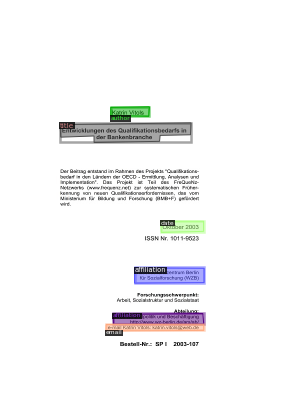

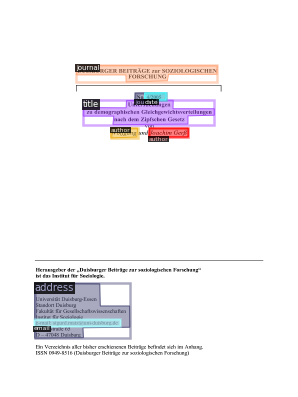

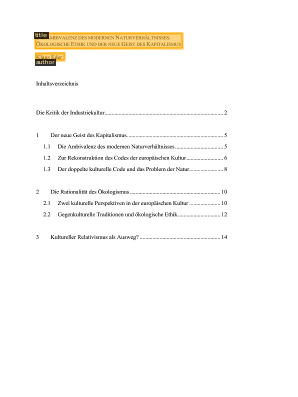

In [8]:
# take a look at the data to see if the images are loaded correctly
from google.colab.patches import cv2_imshow
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=papers_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [9]:
import os
import datetime
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# create the output dir for the trained model
output_dir = os.path.join("/content/drive/My Drive/ML/output", datetime.datetime.now().strftime('%Y%m%dT%H%M'))
os.makedirs(output_dir, exist_ok=True)
# change the config in the .yaml document
cfg = cfg = get_cfg() #load default config
cfg.merge_from_file("/content/drive/My Drive/ML/detectron2/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.OUTPUT_DIR = output_dir #change the output path
cfg.DATASETS.TRAIN = ("my_dataset_train",) #specify the trainning dataset
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "/content/drive/My Drive/ML/model_final_trimmed.pth"  # load intial weights from the pre-trained model in publaynet
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9 
cfg.MODEL.BACKBONE.FREEZE_AT= 4 #freeze the stem and 3 backbone layers
#serialize the training config
cfg_str = cfg.dump()
with open(os.path.join(cfg.OUTPUT_DIR, "train_config.yaml"), "w") as f:  #write the new config in the 'train_config.yaml'
  f.write(cfg_str)
f.close()

# using hpanwar08's trainer specified in the cell above
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()



Config '/content/drive/My Drive/ML/detectron2/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


[07/01 13:27:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (6, 1024) in the checkpoint but (10, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (6,) in the checkpoint but (10,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (20, 1024) in the checkpoint but (36, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (20,) in the checkpoint but (36,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (5, 256, 1, 1) in the checkpoint but (9, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (5,) in the checkpoint but (9,) in the model!


[07/01 13:27:33 d2.engine.train_loop]: Starting training from iteration 0
[07/01 13:28:09 d2.utils.events]:  eta: 2:26:02  iter: 19  total_loss: 3.499  loss_cls: 2.267  loss_box_reg: 0.169  loss_mask: 0.692  loss_rpn_cls: 0.096  loss_rpn_loc: 0.209  time: 1.7258  data_time: 0.0404  lr: 0.000018  max_mem: 2236M
[07/01 13:28:43 d2.utils.events]:  eta: 2:22:19  iter: 39  total_loss: 3.082  loss_cls: 1.914  loss_box_reg: 0.187  loss_mask: 0.685  loss_rpn_cls: 0.102  loss_rpn_loc: 0.169  time: 1.7196  data_time: 0.0064  lr: 0.000036  max_mem: 2236M
[07/01 13:29:17 d2.utils.events]:  eta: 2:20:21  iter: 59  total_loss: 2.348  loss_cls: 1.171  loss_box_reg: 0.174  loss_mask: 0.667  loss_rpn_cls: 0.066  loss_rpn_loc: 0.158  time: 1.7171  data_time: 0.0065  lr: 0.000054  max_mem: 2236M
[07/01 13:29:54 d2.utils.events]:  eta: 2:25:09  iter: 79  total_loss: 1.679  loss_cls: 0.606  loss_box_reg: 0.175  loss_mask: 0.644  loss_rpn_cls: 0.060  loss_rpn_loc: 0.182  time: 1.7482  data_time: 0.0059  lr:

In [10]:
print(output_dir)

/content/drive/My Drive/ML/output/20200701T1327


In [11]:
# Look at training curves in tensorboard:

%load_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>

In [13]:
import os
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val", )
predictor = DefaultPredictor(cfg)

In [ ]:
predictor

WARNING [07/01 16:22:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/01 16:22:24 d2.data.datasets.coco]: Loaded 6 images in COCO format from /content/drive/My Drive/ML/all_May_2020/val/trainval.json


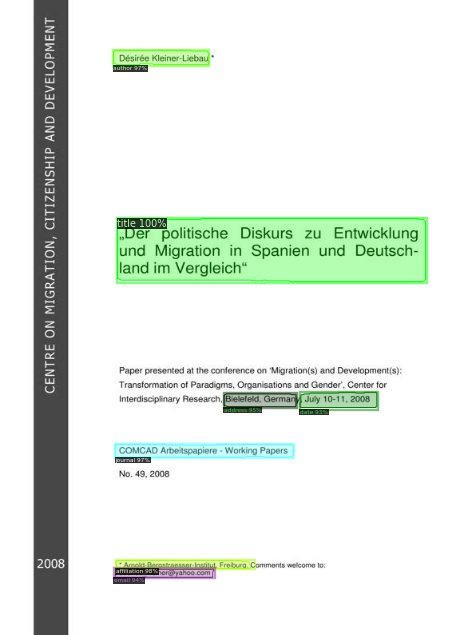

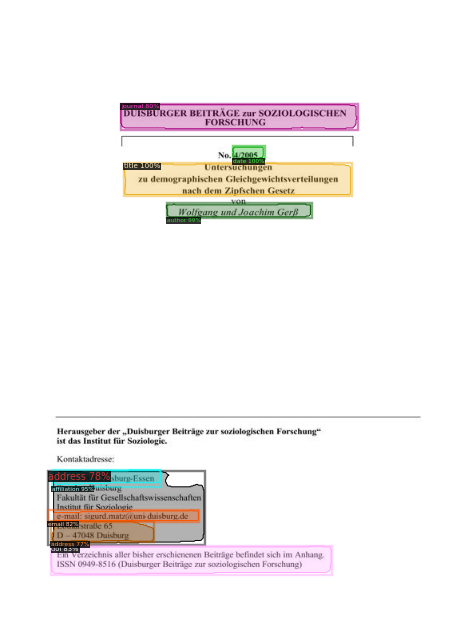

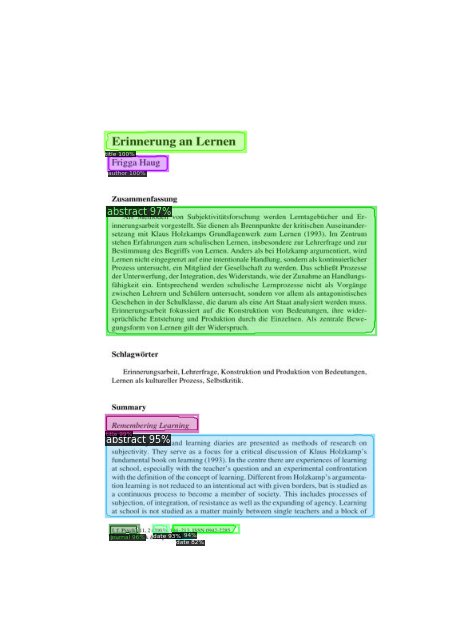

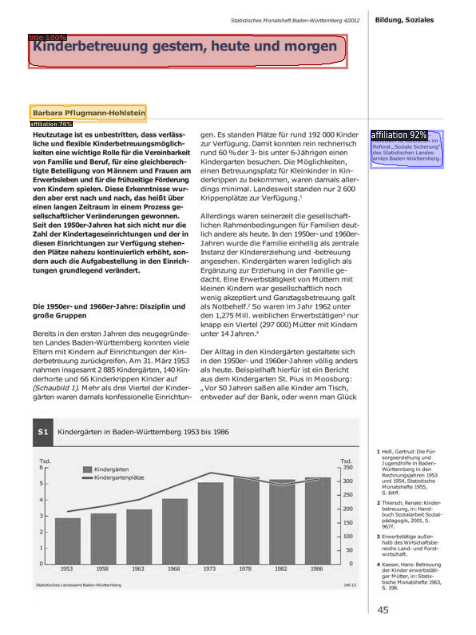

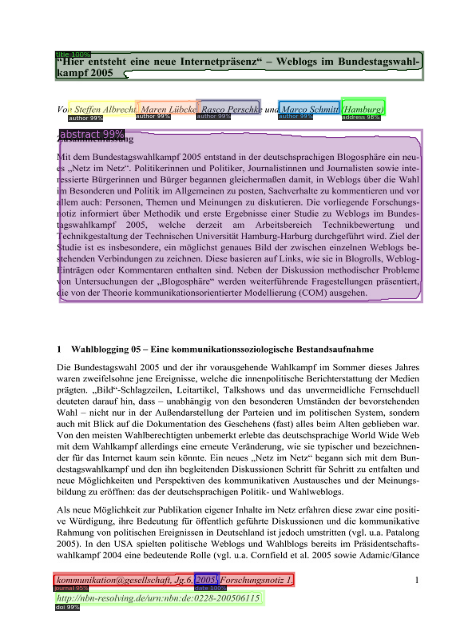

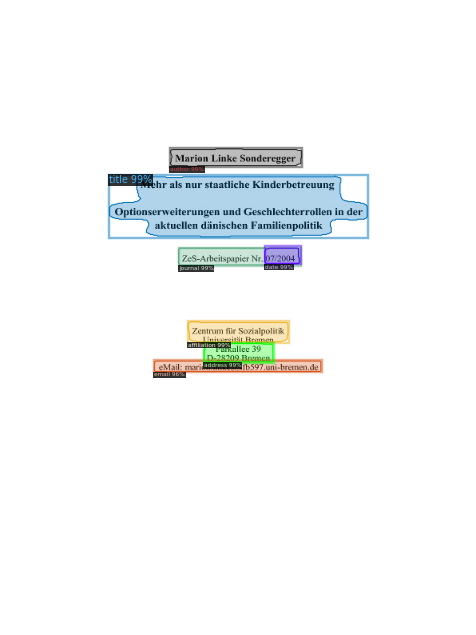

In [14]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts_val = DatasetCatalog.get("my_dataset_val")
for d in dataset_dicts_val:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=papers_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [16]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [07/01 16:22:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/01 16:22:50 d2.data.datasets.coco]: Loaded 6 images in COCO format from /content/drive/My Drive/ML/all_May_2020/val/trainval.json
[07/01 16:22:50 d2.data.build]: Distribution of instances among all 9 categories:
|  category  | #instances   |  category  | #instances   |  category   | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-----------:|:-------------|
|  abstract  | 4            |  address   | 4            | affiliation | 4            |
|   author   | 9            |    date    | 7            |     doi     | 3            |
|   email    | 3            |  journal   | 5            |    title    | 7            |
|            |              |            |              |             |              |
|   total    | 46           |            |              |             |              |
[07/01 16:22:50 d2.data.common]: Seri

OrderedDict([('bbox',
              {'AP': 80.30809628581906,
               'AP-abstract': 97.52475247524752,
               'AP-address': 86.13861386138613,
               'AP-affiliation': 66.996699669967,
               'AP-author': 75.6559405940594,
               'AP-date': 71.12211221122111,
               'AP-doi': 82.24422442244223,
               'AP-email': 96.63366336633663,
               'AP-journal': 72.17821782178217,
               'AP-title': 74.27864214992928,
               'AP50': 88.983184032689,
               'AP75': 88.983184032689,
               'APl': 95.17326732673267,
               'APm': 78.56177805280528,
               'APs': 79.38173817381737}),
             ('segm',
              {'AP': 78.71018649483996,
               'AP-abstract': 97.52475247524752,
               'AP-address': 80.3960396039604,
               'AP-affiliation': 66.996699669967,
               'AP-author': 72.11633663366337,
               'AP-date': 66.23762376237624,
           

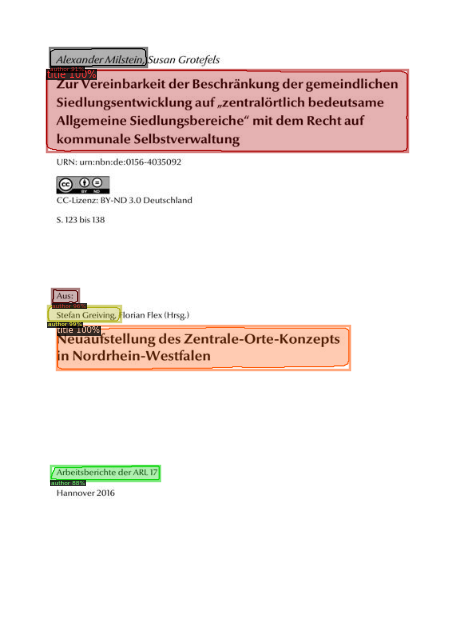

In [17]:
im = cv2.imread("/content/drive/My Drive/ML/all_May_2020/val1/images/49817.jpeg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=papers_metadata, 
               scale=0.8, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
               )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [18]:
# this function takes an image as input and return the predected classes and bounding_box in json file
import json
import re
def predic_json(image_path):
  d = {}
  d['image_name']=image_path.split('/')[-1]
  im = cv2.imread(image_path)
  outputs = predictor(im)
  d['pred_classes']=re.findall('\[(.*?)\]',str(outputs["instances"].pred_classes))
  d['pred_boxes']= str(outputs["instances"].pred_boxes)
  d['pred_boxes'] = d['pred_boxes'][d['pred_boxes'].find( '[[' ):d['pred_boxes'].find( ']]' )+1].strip('\n\t')
  #r = json.dumps(d)
  with open('/content/drive/My Drive/ML/data.json', 'w') as fp:
     json.dump(d, fp, sort_keys=True, indent=4)
  

In [19]:
predic_json("/content/drive/My Drive/ML/all_May_2020/val1/images/49817.jpeg")


